In [56]:
import numpy as np
import pandas as pd
import scipy.linalg as sla

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
np.random.seed(42)

Рассмотрим функцию от двух переменных
$f(x, y) = \sin^2 x + \sin^2 y$ 

In [4]:
def f(x):
    """
    :param x: np.array(np.float) вектор длины 2
    :return: np.float
    """
    return np.sum(np.sin(x)**2)

$f(x) = \sum_{i=1}^{2}\sin^2 x_i$ 

$
\nabla f(x) = \begin{pmatrix} \frac{\partial}{\partial x_1} \sin^2(x_1) \\ \frac{\partial}{\partial x_2} \sin^2(x_2) \end{pmatrix} = \begin{pmatrix} 2 \sin(x_1) \cdot \cos(x_1) \\ 2 \sin(x_2) \cdot \cos(x_2)  \end{pmatrix} = \begin{pmatrix} \sin(2 x_1) \\ \sin(2 x_2) \end{pmatrix}
$


In [8]:
#Сначала реализуем функцию, вычисляющую градиент

def grad_f(x):
    """
    Градиент функциии f, определенной выше.
    :param x: np.array[2]: float вектор длины 2
    :return: np.array[2]: float вектор длины 2
    """
    grad_x = np.sin(2*x)
    
    
    return grad_x

In [ ]:
assert np.allclose(grad_f(np.array([1, 2])),
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [ ]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    функция, которая реализует градиентный спуск в минимум для функции f от двух переменных.
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    if x0 is None:
        x0 = np.random.random(2)

    history = []

    curr_x = x0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_x, f(curr_x)))
        history.append(entry)

        curr_x -= lr * grad_f(curr_x)

    return np.vstack(history)

In [11]:
steps = grad_descent_2d(f, grad_f, lr=0.1, num_iter=20)

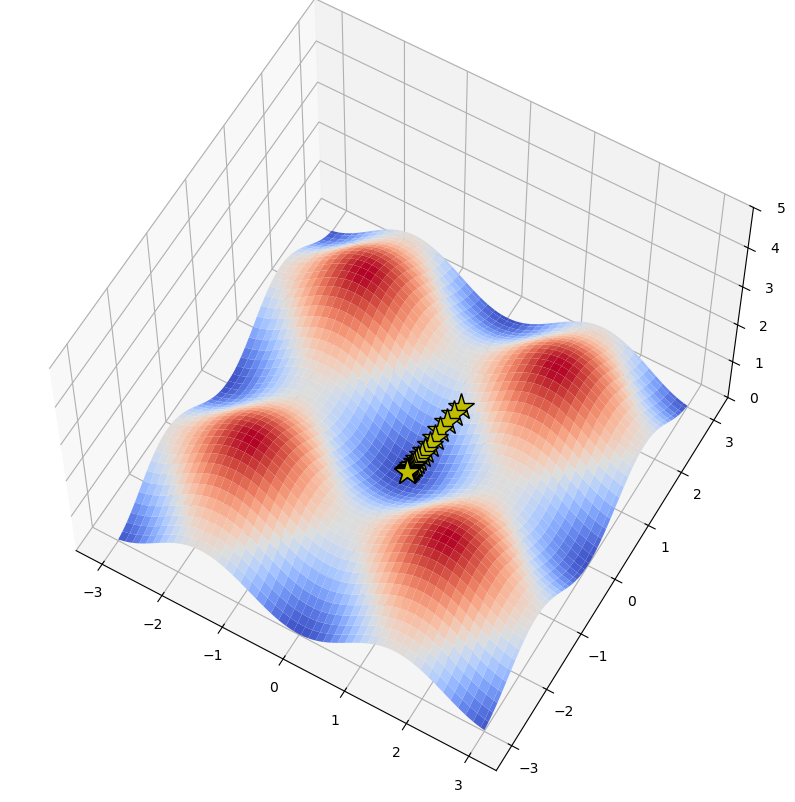

In [18]:
path = []

X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(projection='3d')

zs = np.array([f(np.array([x,y]))
              for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)


ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
        marker='*', markersize=20, zorder=3,
        markerfacecolor='y', lw=3, c='black')

ax.set_zlim(0, 5)
ax.view_init(elev=60)
plt.show()

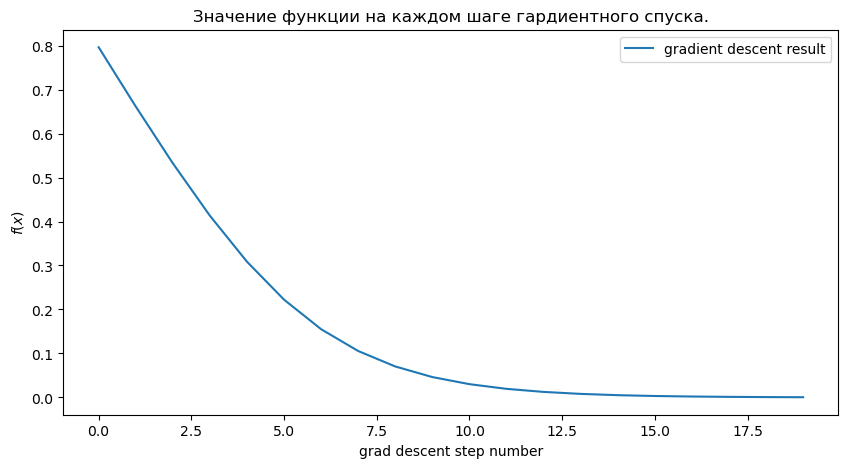

In [20]:
plt.figure(figsize=(10,5))
plt.xlabel('grad descent step number')
plt.ylabel('$f(x)$')
plt.title('Значение функции на каждом шаге гардиентного спуска.')

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label='gradient descent result')
plt.legend()

In [21]:
def generate_batches(X, y, batch_size):
    """
    param X: np.array[n_objects, n_features] --- матрица объекты-признаки
    param y: np.array[n_objects] --- вектор целевых переменных
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    for batch_start in range(0, len(X) - batch_size + 1, batch_size):
        batch_indices = perm[batch_start:batch_start + batch_size]
        
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        yield X_batch, y_batch

In [22]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)

X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all(), "Что-то не так!"
assert (y_fake != y_reconstructed).all(), "Что-то не так!"

assert (np.sort(X_reconstructed, axis=0) == X_fake).all(), "Что-то не так!"

In [23]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

num_batches = 0
for X_batch, y_batch in generate_batches(X_fake, y_fake, 7):
    num_batches += 1

assert num_batches == len(X_fake) // 7, "Что-то не так!"

# логистическая регрессия

$Loss(y, p) = -\sum_{i=1}^{\ell} (y_i \log (p_i) + (1 - y_i) \log (1 - p_i))$


$ \frac{\partial L}{\partial w} = X^T (p - y)$

In [61]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [25]:
class MyLogisticRegression(object):
    def __init__(self):
        self.w = None

    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        l, n = X.shape
        if self.w is None:
            np.random.seed(42)
            self.w = np.random.randn(n + 1)

        X_train = np.concatenate((np.ones((l, 1)), X), axis=1)

        losses = []

        for i in range(epochs):
            for X_batch, y_batch in generate_batches(X_train, y, batch_size):
                
                predictions = self._predict_proba_internal(X_batch)
                loss = self.__loss(y_batch, predictions)

                assert (np.array(loss).shape == tuple()), "Лосс должен быть скаляром!"

                losses.append(loss)

                grad = self.get_grad(X_batch, y_batch, predictions)
                self.w -= lr * grad  # Обновление весов

        return losses

    def get_grad(self, X_batch, y_batch, predictions):
        """

        param X_batch: np.array[batch_size, n_features + 1] --- матрица объекты-признаки
        param y_batch: np.array[batch_size] --- батч целевых переменных
        param predictions: np.array[batch_size] --- батч вероятностей классов

        Принимает на вход X_batch с уже добавленной колонкой единиц.
        Выдаёт градиент функции потерь в логистической регрессии
        как сумму градиентов функции потерь на всех объектах батча
        ВНИМАНИЕ! Нулевая координата вектора весов -- это BIAS, а не вес признака.
        Также не нужно ДЕЛИТЬ ГРАДИЕНТ НА РАЗМЕР БАТЧА:
        нас интересует не среднее, а сумма.
        В качестве оператора умножения матриц можно использовать @

        Выход -- вектор-столбец градиентов для каждого веса (np.array[n_features + 1])
        """

        errors = predictions - y_batch
        grad_basic = X_batch.T @ errors 
        assert grad_basic.shape == (X_batch.shape[1],) , "Градиенты должны быть столбцом из k_features + 1 элементов"

        return grad_basic

    def predict_proba(self, X):
        l, n = X.shape
        X_ = np.concatenate((np.ones((l, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def _predict_proba_internal(self, X):
        """
        Возможно, вы захотите использовать эту функцию вместо predict_proba, поскольку
        predict_proba конкатенирует вход с вектором из единиц, что не всегда удобно
        для внутренней логики вашей программы
        """
        return sigmoid(logit(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

    def get_weights(self):
        return self.w.copy()
        # copy тут используется неспроста. Если copy не использовать, то get_weights()
        # выдаст ссылку на объект, а, значит, модифицируя результат применения функции
        # get_weights(), вы модифицируете и веса self.w. Если вы хотите модифицировать веса,
        # (например, в fit), используйте self.w

    def __loss(self, y, p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

In [26]:
m = MyLogisticRegression()
X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([-0.38,  0.22, -3.2 , -0.93])), "Что-то не так!"

In [27]:
np.random.seed(42)
m = MyLogisticRegression()
X = np.random.rand(100,3)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([23.8698149, 25.27049356, 24.4139452])), "Что-то не так!"

# Логистическая регрессия с $l_1$ и $l_2$ регуляризацией (elastic net).

$L_1 (w) = \alpha \sum_{j=1}^{n}|w_j| $

$L_2 (w) = \beta\sum_{j=1}^{n}w_j^2$

$\frac{\partial L_1}{\partial w_1} = \alpha \cdot \mathrm{sign}(w_1)$

$ \frac{\partial L_2}{\partial w_1} = 2\beta $

In [45]:
class MyElasticLogisticRegression(MyLogisticRegression):
    def __init__(self, l1_coef, l2_coef):
        super().__init__()  
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef

    def get_grad(self, X_batch, y_batch, predictions):
        """
        Выдаёт градиент функции потерь в логистической регрессии с регуляризаторами
        как сумму градиентов функции потерь на всех объектах батча + регуляризационное слагаемое.
        """
        errors = predictions - y_batch
        grad_basic = X_batch.T @ errors 

        grad_l1 = np.zeros_like(self.w)
        grad_l1 = self.l1_coef * np.sign(self.w) 
        grad_l1[0] = 0
        
        grad_l2 = np.zeros_like(self.w)
        grad_l2 = 2 * self.l2_coef * self.w 
        grad_l2[0] = 0

        assert grad_l1[0] == grad_l2[0] == 0, "Bias в регуляризационные слагаемые не входит!"
        assert grad_basic.shape == grad_l1.shape == grad_l2.shape == (X_batch.shape[1],), "Градиенты должны быть столбцом из k_features + 1 элементов"
        return grad_basic + grad_l1 + grad_l2


In [46]:
m = MyElasticLogisticRegression(.2,.2)
X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
m.w = np.array([1,1,1,1])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([-0.38,  0.82, -2.6 , -0.33])), "Что-то не так!"


In [47]:
np.random.seed(42)
m = MyElasticLogisticRegression(.2, .2)
X = np.random.rand(100,3)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
m.w = np.array([1,1,1,1])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([49.11489408, 24.4698149, 25.87049356, 25.0139452])), "Что-то не так!"


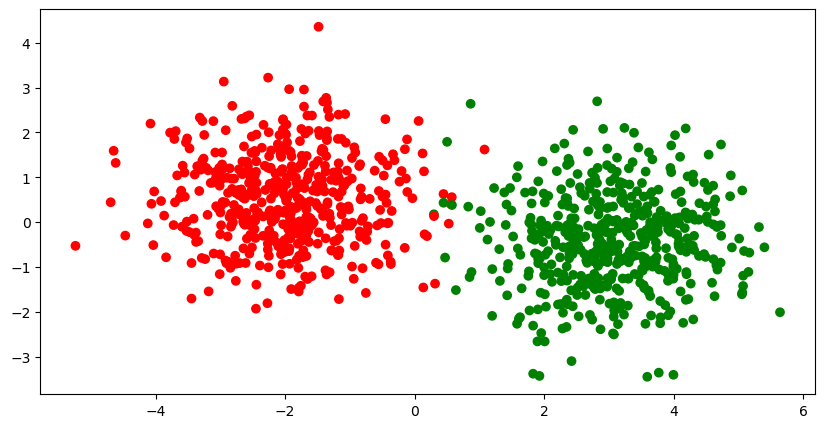

In [49]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)
#y = y.reshape(-1, 1)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])

plt.figure(figsize=(10,5))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [50]:
clf = MyElasticLogisticRegression(0.1, 0.1)
clf.fit(X, y, epochs=1000)
w = clf.get_weights()

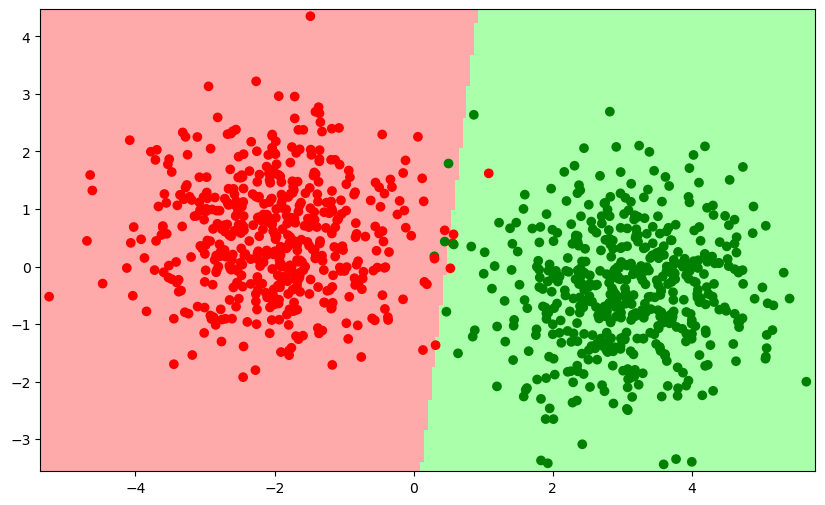

In [52]:
plt.figure(figsize=(10,6))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)

In [53]:
data = pd.read_csv('./dataset/train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

In [67]:
%%capture
l1_coef = 0.2 
l2_coef = 0.2  

pipeline = make_pipeline(
    StandardScaler(),  
    MyElasticLogisticRegression(l1_coef=l1_coef, l2_coef=l2_coef) 
)
mean_accuracy = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy').mean()

In [69]:
print(f"Mean accuracy of Logistic Regression for two classes is {mean_accuracy}")

Mean accuracy of Logistic Regression for two classes is 0.9921730121430308
